Importing the Essential Libraries and loading data :

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('energy_efficiency_data.csv')
df.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


Now, we check the data set information :

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


Check the missing and duplicates values :

In [4]:
df.columns[df.isnull().any()]

Index([], dtype='object')

In [5]:
df.isnull().sum()

Relative_Compactness         0
Surface_Area                 0
Wall_Area                    0
Roof_Area                    0
Overall_Height               0
Orientation                  0
Glazing_Area                 0
Glazing_Area_Distribution    0
Heating_Load                 0
Cooling_Load                 0
dtype: int64

In [6]:
df.duplicated().sum() 

0

Exploratory Data Analysis :

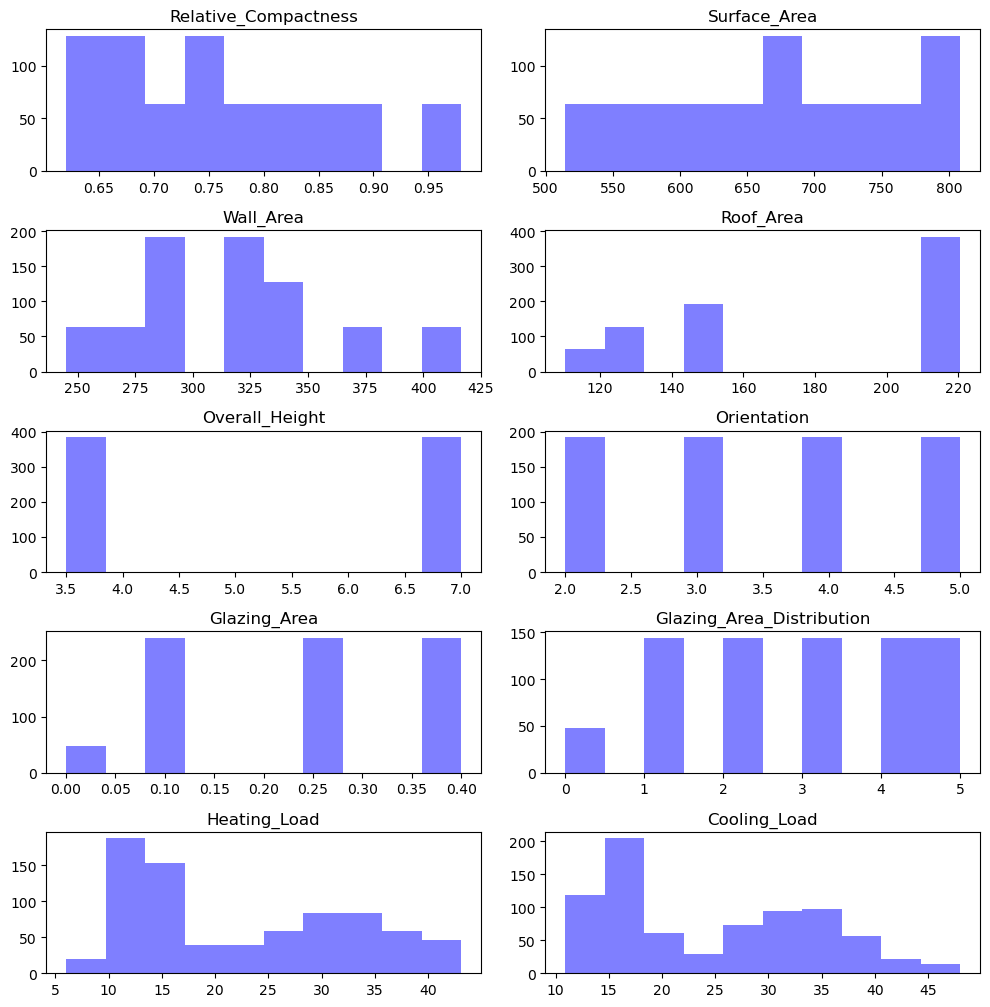

In [7]:
num_list = list(df.columns)

fig = plt.figure(figsize=(10,30))

for i in range(len(num_list)):
    plt.subplot(15,2,i+1)
    plt.title(num_list[i])
    plt.hist(df[num_list[i]],color='blue',alpha=0.5)

plt.tight_layout()

In [8]:
df.describe().round(1)

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
count,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0
mean,0.8,671.7,318.5,176.6,5.2,3.5,0.2,2.8,22.3,24.6
std,0.1,88.1,43.6,45.2,1.8,1.1,0.1,1.6,10.1,9.5
min,0.6,514.5,245.0,110.2,3.5,2.0,0.0,0.0,6.0,10.9
25%,0.7,606.4,294.0,140.9,3.5,2.8,0.1,1.8,13.0,15.6
50%,0.8,673.8,318.5,183.8,5.2,3.5,0.2,3.0,19.0,22.1
75%,0.8,741.1,343.0,220.5,7.0,4.2,0.4,4.0,31.7,33.1
max,1.0,808.5,416.5,220.5,7.0,5.0,0.4,5.0,43.1,48.0


<AxesSubplot:>

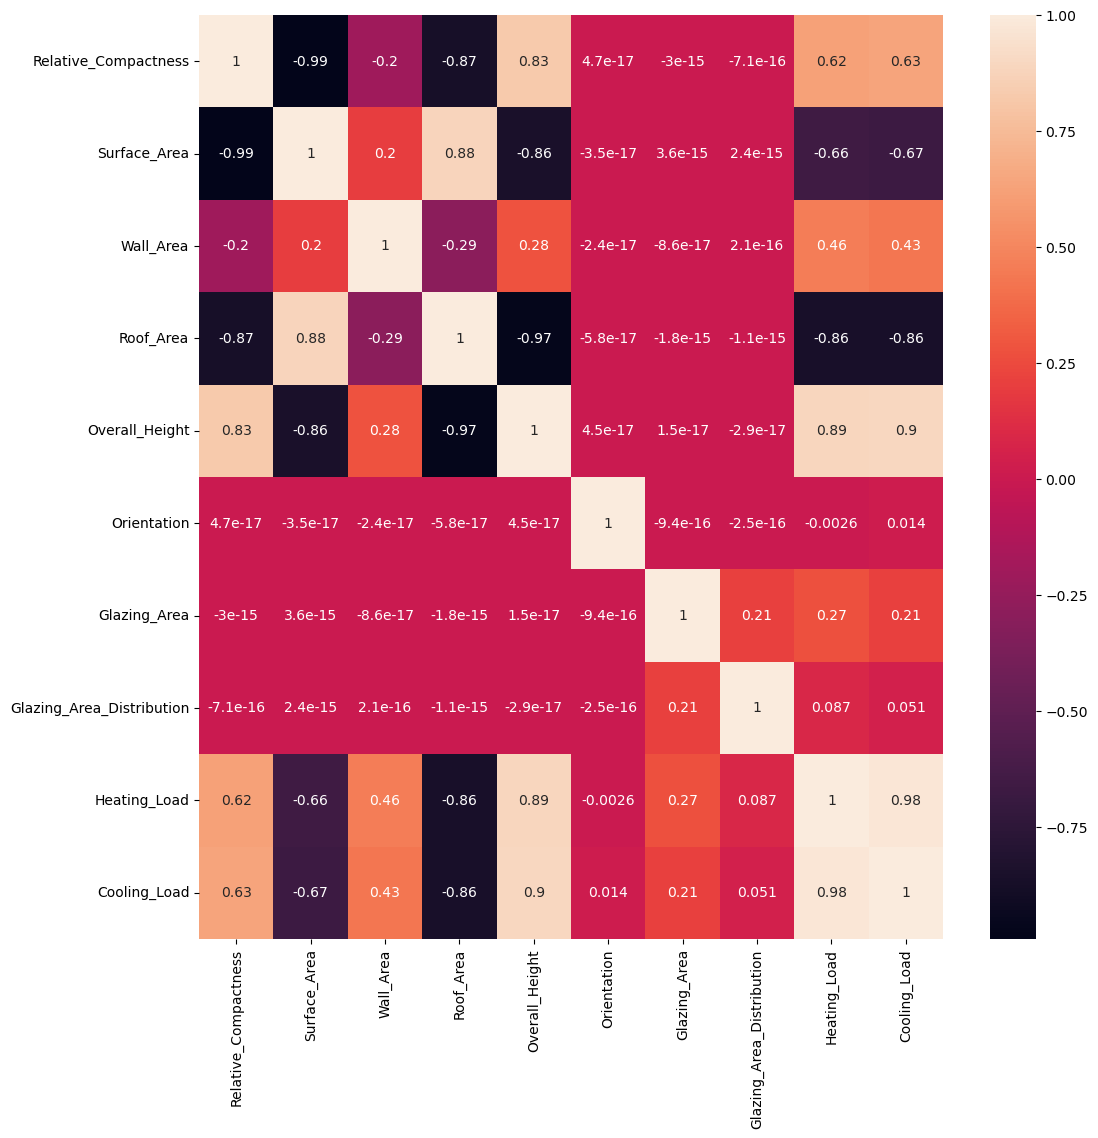

In [9]:
correlation = df.corr()
plt.figure(figsize=(12,12))
sns.heatmap(correlation,annot=True)


It can be noted that we only have numerical variables.  In the following, we will implement a model to classify buildings according to their total energy charges (heating + cooling). Therefore, our aim is to use classification models. We will therefore modify the target variables:

In [10]:
df['charges_sum']= df['Heating_Load'] + df['Cooling_Load']
df.head()


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load,charges_sum
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33,36.88
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33,36.88
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33,36.88
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33,36.88
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28,49.12


In [11]:
df['charges_sum'].describe()

count    768.000000
mean      46.894961
std       19.484947
min       16.950000
25%       28.750000
50%       40.970000
75%       64.335000
max       89.950000
Name: charges_sum, dtype: float64

In [12]:

charges_classes = pd.cut(x = df['charges_sum'], bins = [0, 28.75, 40.97, 64.33, 89.95],labels = [0,1,2,3])

Prepraring data for prediction :

In [13]:
df_X = df.iloc[:,0:8]
target = charges_classes



In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_X, target, test_size=0.2) 


Standardizing the Data :  StandardScaler() adjusts the mean of the features as 0 and standard deviation of features as 1.

In [16]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


Model selection :

KNN :

In [17]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train_scaled, y_train)

param = {'n_neighbors' : np.arange(2,40)}
grid_knn = model_selection.GridSearchCV(estimator=knn, param_grid=param)
grille = grid_knn.fit(X_train_scaled, y_train)
print(grid_knn.best_params_)
print (grid_knn.best_score_)


y_pred = grid_knn.predict(X_test_scaled)
precision = grid_knn.score(X_test_scaled, y_test)
print(precision*100)

c:\Users\beaux\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\beaux\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

{'n_neighbors': 3}
0.8745834999333602
93.5064935064935


c:\Users\beaux\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\beaux\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [18]:
print('Matrice de confusion : \n', confusion_matrix(y_test, y_pred))

Matrice de confusion : 
 [[35  2  0  0]
 [ 0 39  3  0]
 [ 0  2 29  2]
 [ 0  0  1 41]]


SVM :

In [19]:
svm = svm.SVC(kernel = 'poly')
svm.fit(X_train_scaled, y_train)
parametre = {'C' : [0.1, 1, 10, 30], 'kernel' : ['linear','sigmoid','rbf']}
grid_svm = model_selection.GridSearchCV(estimator=svm, param_grid=parametre)
grille = grid_svm.fit(X_train_scaled, y_train)
print(grid_svm.best_params_)
print (grid_svm.best_score_)

y_pred_svm = grid_svm.predict(X_test_scaled)
precision = grid_svm.score(X_test_scaled, y_test)
print(precision*100)



{'C': 30, 'kernel': 'rbf'}
0.9234839397574304
92.85714285714286


In [20]:
print('Matrice de confusion : \n', confusion_matrix(y_test, y_pred_svm))

Matrice de confusion : 
 [[35  2  0  0]
 [ 0 40  2  0]
 [ 0  4 28  1]
 [ 0  0  2 40]]


RandomForest :

In [21]:
rf = ensemble.RandomForestClassifier(max_features = 'sqrt')
rf.fit(X_train_scaled, y_train)


parametres = {'max_features' : ['sqrt', 'log2', None], 'min_samples_split' : np.arange(2,30)}
grid_rf = model_selection.GridSearchCV(estimator=rf, param_grid=parametres)
grille = grid_rf.fit(X_train_scaled, y_train)
print(grid_rf.best_params_)
print (grid_rf.best_score_)

y_pred_rf = grid_rf.predict(X_test_scaled)
precision = grid_rf.score(X_test_scaled, y_test)
print(precision*100)


{'max_features': 'sqrt', 'min_samples_split': 19}
0.9446488071438092
94.8051948051948


In [22]:
print('Matrice de confusion : \n', confusion_matrix(y_test, y_pred_rf))

Matrice de confusion : 
 [[35  2  0  0]
 [ 0 40  2  0]
 [ 0  1 31  1]
 [ 0  0  2 40]]


XGBoost :

In [23]:
xg = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')
xg.fit(X_train_scaled, y_train)


parametres = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}
grid_xg = model_selection.GridSearchCV(estimator=xg, param_grid=parametres)
grille = grid_xg.fit(X_train_scaled, y_train)
print(grid_xg.best_params_)
print (grid_xg.best_score_)

y_pred_xg = grid_xg.predict(X_test_scaled)
precision = grid_xg.score(X_test_scaled, y_test)
print(precision*100)

c:\Users\beaux\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\beaux\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\beaux\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\beaux\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\beaux\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\beaux\anaconda3\lib\site-packages\xgboost\sklearn.p

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}
0.9413967746234839
95.45454545454545


In [24]:
print('Matrice de confusion : \n', confusion_matrix(y_test, y_pred_xg))

Matrice de confusion : 
 [[36  1  0  0]
 [ 0 40  2  0]
 [ 0  2 29  2]
 [ 0  0  0 42]]


Conclusion :

Le modèle XGBoost semble avoir la meilleure précision pour ce dataset